In [1]:
# This dataset analyzes the COVID-19 data for Colombia and builds the GeoJSON map counting active cases by department
# Author: Fabian Peña
# Creation date:
# Last modification date: 08/06/2020

In [48]:
import pandas as pd
import geopandas as gpd

from sodapy import Socrata

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_profiling import ProfileReport

# INS data

In [49]:
# Creating the Socrata client
client = Socrata( 'www.datos.gov.co', None )

In [50]:
# Loading the COVID-19 data for Colombia
results = client.get( 'gt2j-8ykr', limit = 100000 )
covid = pd.DataFrame.from_records(results)
covid.rename( columns = { 'id_de_caso': 'ID caso',
                         'fecha_de_notificaci_n': 'Fecha notificacion',
                         'c_digo_divipola': 'Codigo ciudad',
                         'ciudad_de_ubicaci_n': 'Ciudad',
                         'departamento': 'Departamento',
                         'atenci_n': 'Atencion',
                         'edad': 'Edad',
                         'sexo': 'Sexo',
                         'tipo': 'Tipo',
                         'estado': 'Estado',
                         'pa_s_de_procedencia': 'Pais procedencia',
                         'fis': 'Fecha inicio sintomas',
                         'fecha_de_muerte': 'Fecha muerte',
                         'fecha_diagnostico': 'Fecha diagnostico',
                         'fecha_recuperado': 'Fecha recuperacion',
                         'fecha_reporte_web': 'Fecha reporte web',
                         'tipo_recuperaci_n': 'Tipo recuperacion' }, inplace = True )

In [51]:
# Getting the size of the df
covid.shape

(88591, 21)

In [52]:
# Add a new column for asimptomatic observations
covid.loc[ covid[ 'Fecha inicio sintomas' ] == 'Asintomático', 'Asintomatico' ] = True
covid.loc[ covid[ 'Fecha inicio sintomas' ] != 'Asintomático', 'Asintomatico' ] = False
covid[ 'Asintomatico' ] = covid[ 'Asintomatico' ].astype( bool )

In [53]:
# Casting date columns
covid[ 'Fecha notificacion' ] = pd.to_datetime( covid[ 'Fecha notificacion' ] )
covid[ 'Fecha inicio sintomas' ] = pd.to_datetime( covid[ 'Fecha inicio sintomas' ], errors = 'coerce' )
covid[ 'Fecha muerte' ] = pd.to_datetime( covid[ 'Fecha muerte' ], errors = 'coerce' )
covid[ 'Fecha diagnostico' ] = pd.to_datetime( covid[ 'Fecha diagnostico' ], errors = 'coerce' )
covid[ 'Fecha recuperacion' ] = pd.to_datetime( covid[ 'Fecha recuperacion' ], errors = 'coerce' )
covid[ 'Fecha reporte web' ] = pd.to_datetime( covid[ 'Fecha reporte web' ] )

In [54]:
# Unifying values for sex
covid[ 'Sexo' ].replace( { 'm': 'M', 'f': 'F' }, inplace = True )

In [55]:
# Unifying values for status
covid[ 'Estado' ].replace( { 'leve': 'Leve', 'LEVE': 'Leve' }, inplace = True )

In [56]:
# Unifying values for atention
covid[ 'Atencion' ].replace( { 'casa': 'Casa', 'N/A': None }, inplace = True )

In [57]:
# Unifying values for procedence
covid[ 'Pais procedencia' ].replace( { '-   -': None }, inplace = True )

In [58]:
covid.loc[ covid[ 'Fecha recuperacion' ].notnull(), 'Recuperado' ] = True
covid.loc[ covid[ 'Fecha recuperacion' ].isnull(), 'Recuperado' ] = False

In [59]:
covid.loc[ covid[ 'Fecha muerte' ].notnull(), 'Fallecido' ] = True
covid.loc[ covid[ 'Fecha muerte' ].isnull(), 'Fallecido' ] = False

In [60]:
covid[ 'Edad' ] = covid[ 'Edad' ].astype( int )

In [61]:
def get_age_group( x ):
    if x <= 19:
        return '0 - 19'
    elif x > 19 and x <= 39:
        return '20 - 39'
    elif x > 39 and x <= 59:
        return '40 - 59'
    elif x > 59 and x <= 79:
        return '60 - 79'
    elif x > 79:
          return '80+'
    else:
        return None

covid[ 'Grupo edad' ] = covid[ 'Edad' ].apply( get_age_group )

In [62]:
# Getting the column types
covid.dtypes

ID caso                          object
Fecha notificacion       datetime64[ns]
Codigo ciudad                    object
Ciudad                           object
Departamento                     object
Atencion                         object
Edad                              int64
Sexo                             object
Tipo                             object
Estado                           object
Pais procedencia                 object
Fecha inicio sintomas    datetime64[ns]
Fecha diagnostico        datetime64[ns]
Fecha recuperacion       datetime64[ns]
Fecha reporte web        datetime64[ns]
Tipo recuperacion                object
codigo_departamento              object
codigo_pais                      object
pertenencia_etnica               object
Fecha muerte             datetime64[ns]
nombre_grupo_etnico              object
Asintomatico                       bool
Recuperado                       object
Fallecido                        object
Grupo edad                       object


In [63]:
# Showing the firts rows
covid.head()

,ID caso,Fecha notificacion,Codigo ciudad,Ciudad,Departamento,Atencion,Edad,Sexo,Tipo,Estado,...,Tipo recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,Fecha muerte,nombre_grupo_etnico,Asintomatico,Recuperado,Fallecido,Grupo edad
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,...,PCR,11,380,Otro,NaT,NaN,False,True,False,0 - 19
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,...,PCR,76,724,Otro,NaT,NaN,False,True,False,20 - 39
2,3,2020-03-07,05001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,...,PCR,5,724,Otro,NaT,NaN,False,True,False,40 - 59
3,4,2020-03-09,05001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,...,PCR,5,NaN,Otro,NaT,NaN,False,True,False,40 - 59
4,5,2020-03-09,05001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,...,PCR,5,NaN,Otro,NaT,NaN,False,True,False,20 - 39


In [64]:
# How many observations have null atention
covid.loc[ covid[ 'Atencion' ].isnull() ].shape

(136, 25)

In [65]:
# How many observations have null status
covid.loc[ covid[ 'Estado' ].isnull() ].shape

(0, 25)

In [66]:
del covid[ 'nombre_grupo_etnico' ]
del covid[ 'pertenencia_etnica' ]
del covid[ 'codigo_pais' ]

In [21]:
del covid[ 'codigo_departamento' ]

In [67]:
covid.to_csv( './data/covid19.csv', index = False )

# Indicators

In [68]:
covid[ 'ID caso' ].nunique()

88591

In [69]:
covid.loc[ covid[ 'Recuperado' ] == True ].shape[ 0 ]

36273

In [70]:
covid.loc[ covid[ 'Fallecido' ] == True ].shape[ 0 ]

3024

In [71]:
covid.loc[ ( covid[ 'Atencion' ] == 'Hospital' ) ].shape[ 0 ]

5347

In [72]:
covid.loc[ ( covid[ 'Atencion' ] == 'Hospital UCI' ) ].shape[ 0 ]

739

# Time series

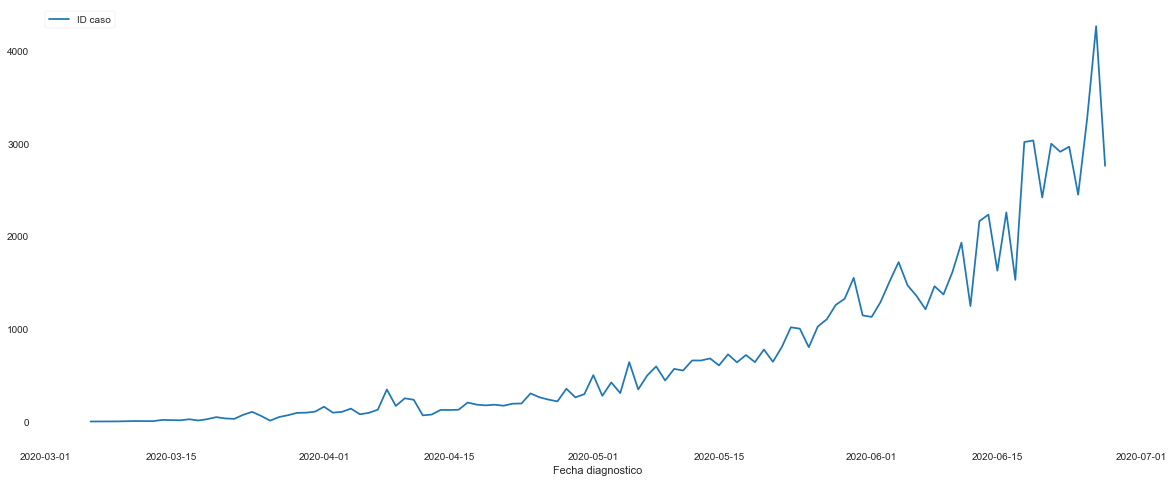

In [73]:
# Plotting diagnosed cases by day
covid.groupby( [ covid[ 'Fecha diagnostico' ].dt.date ] ).agg( { 'ID caso': 'count' } ).plot( figsize = ( 20, 8 ) )

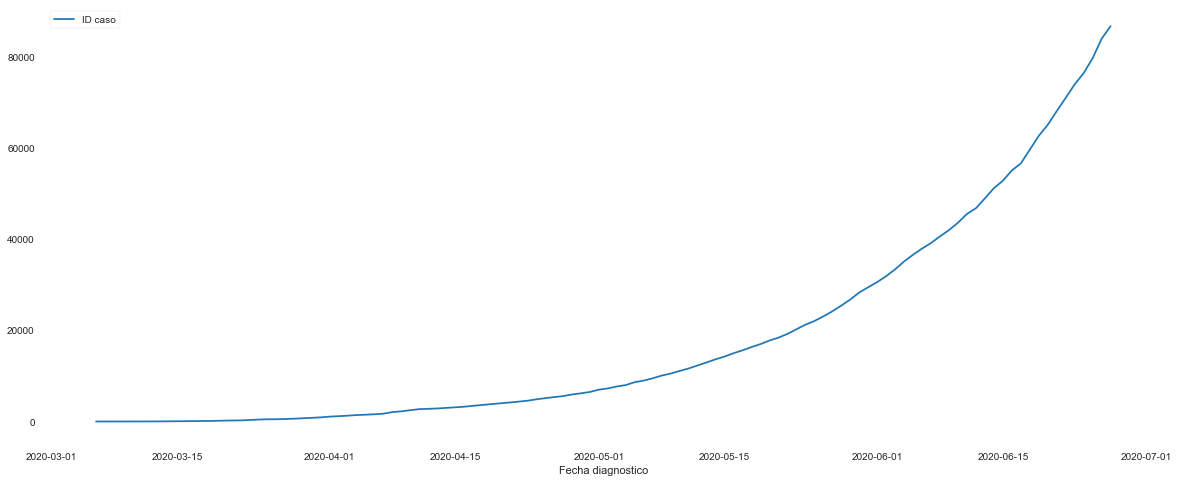

In [74]:
# Plotting diagnosed cases by day (cumulative sum)
covid.groupby( [ covid[ 'Fecha diagnostico' ].dt.date ] ).agg( { 'ID caso': 'count' } ).cumsum().plot( figsize = ( 20, 8 ) )

In [75]:
# Preparing and merging the groupings in one dataframe

diagnosed = covid.groupby( [ covid[ 'Fecha diagnostico' ].dt.date ] ) \
    .agg( { 'ID caso': 'count' } ) \
    .cumsum() \
    .rename( columns = { 'Fecha diagnostico': 'Fecha', 'ID caso': 'Diagnosticados' } )

recovered = covid.groupby( [ covid[ 'Fecha recuperacion' ].dt.date ] )  \
    .agg( { 'ID caso': 'count' } ) \
    .cumsum() \
    .rename( columns = { 'Fecha recuperacion': 'Fecha', 'ID caso': 'Recuperados' } )

deaths = covid.groupby( [ covid[ 'Fecha muerte' ].dt.date ] )  \
    .agg( { 'ID caso': 'count' } ) \
    .cumsum() \
    .rename( columns = { 'Fecha muerte': 'Fecha', 'ID caso': 'Fallecidos' } )

infections = diagnosed.merge( recovered, how = 'outer', left_index = True, right_index = True )
infections = infections.merge( deaths, how = 'outer', left_index = True, right_index = True )
infections.fillna( 0, inplace = True )

In [76]:
infections.tail()

,Diagnosticados,Recuperados,Fallecidos
2020-06-23,73850,31622.0,2867.0
2020-06-24,76297,32694.0,2935.0
2020-06-25,79564,34183.0,2986.0
2020-06-26,83829,35353.0,3017.0
2020-06-27,86587,36273.0,3024.0


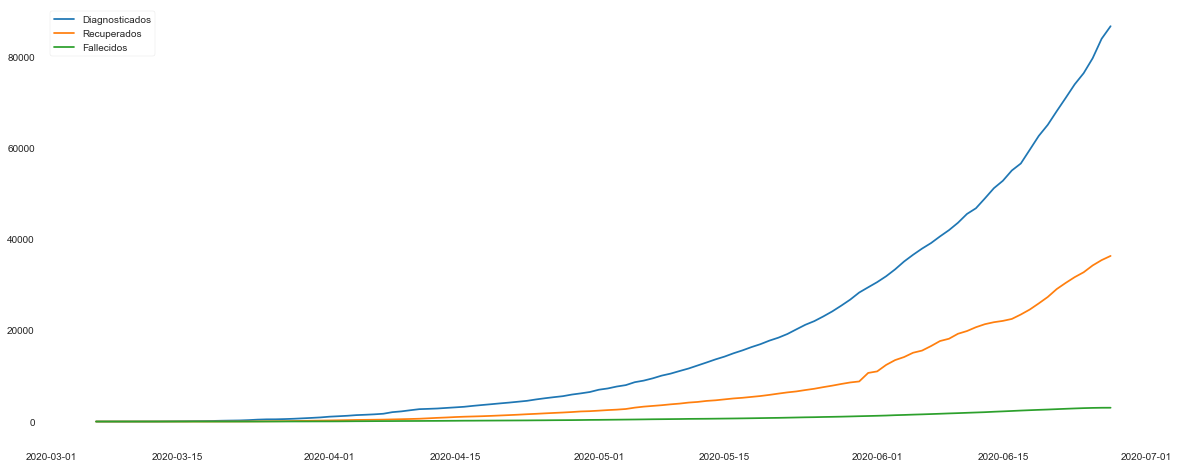

In [77]:
# Plotting diagnosed and recovered cases by day
infections.plot( figsize = ( 20, 8 ) )

In [78]:
# Calculating the difference between diagnosed and recovered cases
infections[ 'Casos activos' ] = infections[ 'Diagnosticados' ] - infections[ 'Recuperados' ]

In [79]:
infections.tail()

,Diagnosticados,Recuperados,Fallecidos,Casos activos
2020-06-23,73850,31622.0,2867.0,42228.0
2020-06-24,76297,32694.0,2935.0,43603.0
2020-06-25,79564,34183.0,2986.0,45381.0
2020-06-26,83829,35353.0,3017.0,48476.0
2020-06-27,86587,36273.0,3024.0,50314.0


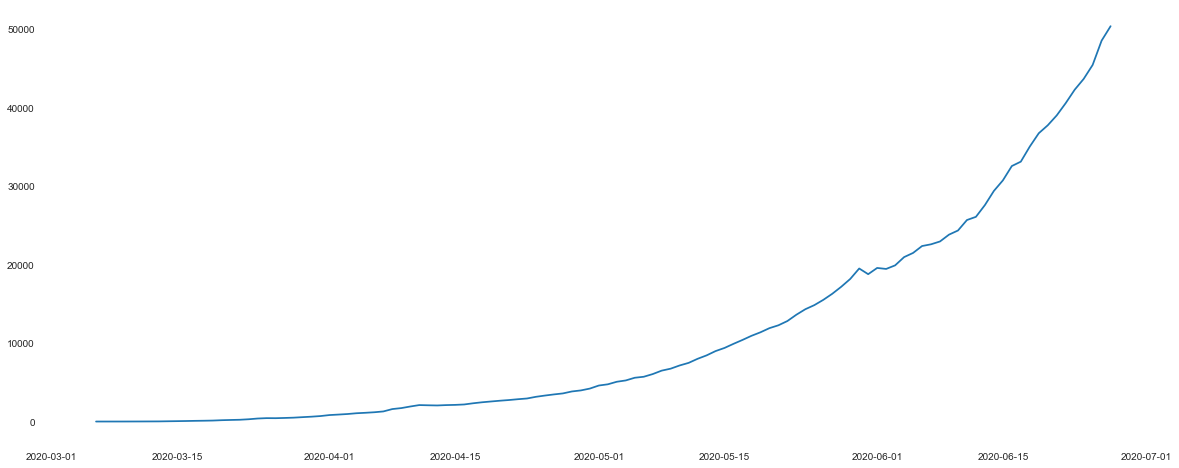

In [80]:
# Plotting difference cases by day
infections[ 'Casos activos' ].plot( figsize = ( 20, 8 ) )

# Geo

In [81]:
covid.head()

,ID caso,Fecha notificacion,Codigo ciudad,Ciudad,Departamento,Atencion,Edad,Sexo,Tipo,Estado,...,Fecha diagnostico,Fecha recuperacion,Fecha reporte web,Tipo recuperacion,codigo_departamento,Fecha muerte,Asintomatico,Recuperado,Fallecido,Grupo edad
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,...,2020-03-06,2020-03-13,2020-03-06,PCR,11,NaT,False,True,False,0 - 19
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,...,2020-03-09,2020-03-19,2020-03-09,PCR,76,NaT,False,True,False,20 - 39
2,3,2020-03-07,05001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,...,2020-03-09,2020-03-15,2020-03-09,PCR,5,NaT,False,True,False,40 - 59
3,4,2020-03-09,05001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,...,2020-03-11,2020-03-26,2020-03-11,PCR,5,NaT,False,True,False,40 - 59
4,5,2020-03-09,05001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,...,2020-03-11,2020-03-23,2020-03-11,PCR,5,NaT,False,True,False,20 - 39


In [82]:
covid[ 'Atencion' ].value_counts( dropna = False )

Casa            43157
Recuperado      36273
Hospital         5347
Fallecido        2939
Hospital UCI      739
NaN               136
Name: Atencion, dtype: int64

In [40]:
def extract_depto( x ):
    x = str( x )[ :-3 ]
    try:
        return int( x )
    except:
        return 0
    
covid[ 'codigo_departamento' ] = covid[ 'Codigo DIVIPOLA' ].apply( lambda x: extract_depto( x ) )

KeyError: 'Codigo DIVIPOLA'

In [92]:
cases_by_depto = covid.loc[ ~covid[ 'Atencion' ].isin( [ 'Recuperado', 'Fallecido' ] ) ].groupby( 'codigo_departamento' ).agg( { 'ID caso': 'count' } ).reset_index().rename( columns = { 'ID caso': 'Casos' } )

In [94]:
cases_by_depto[ 'codigo_departamento' ] = cases_by_depto[ 'codigo_departamento' ].astype( int )

In [95]:
cases_by_depto.dtypes

codigo_departamento    int64
Casos                  int64
dtype: object

In [96]:
cases_by_depto.head()

,codigo_departamento,Casos
0,11,15136
1,13,4331
2,15,134
3,17,75
4,18,8


In [97]:
departamentos = gpd.read_file( './data/geo/colombia/departamentos.json' )

In [98]:
departamentos.head()

,departamento,codigo_departamento,geometry
0,SAN ANDRÉS PROVIDENCIA Y SANTA CATALINA,88,"MULTIPOLYGON (((-81.70399 12.59487, -81.70394 ..."
1,CAUCA,19,"MULTIPOLYGON (((-76.44619 3.31639, -76.44597 3..."
2,VALLE DEL CAUCA,76,"MULTIPOLYGON (((-76.08076 5.04322, -76.08033 5..."
3,ATLÁNTICO,8,"MULTIPOLYGON (((-74.83855 11.06027, -74.83297 ..."
4,RISARALDA,66,"MULTIPOLYGON (((-76.00825 5.56368, -76.00765 5..."


In [99]:
cases_by_depto = departamentos.merge( cases_by_depto, how = 'left', on = 'codigo_departamento' )
cases_by_depto[ 'Casos' ] = cases_by_depto[ 'Casos' ].fillna( 0 )

In [101]:
cases_by_depto

,departamento,codigo_departamento,geometry,Casos
0,SAN ANDRÉS PROVIDENCIA Y SANTA CATALINA,88,"MULTIPOLYGON (((-81.70399 12.59487, -81.70394 ...",7.0
1,CAUCA,19,"MULTIPOLYGON (((-76.44619 3.31639, -76.44597 3...",178.0
2,VALLE DEL CAUCA,76,"MULTIPOLYGON (((-76.08076 5.04322, -76.08033 5...",4970.0
3,ATLÁNTICO,8,"MULTIPOLYGON (((-74.83855 11.06027, -74.83297 ...",13954.0
4,RISARALDA,66,"MULTIPOLYGON (((-76.00825 5.56368, -76.00765 5...",215.0
5,ANTIOQUIA,5,"MULTIPOLYGON (((-76.41356 8.74766, -76.41269 8...",2371.0
6,QUINDÍO,63,"MULTIPOLYGON (((-75.70002 4.72006, -75.69970 4...",43.0
7,BOLÍVAR,13,"MULTIPOLYGON (((-75.25555 10.79960, -75.25546 ...",4331.0
8,CAQUETÁ,18,"MULTIPOLYGON (((-74.89423 2.95852, -74.89410 2...",8.0
9,MAGDALENA,47,"MULTIPOLYGON (((-74.04046 11.34612, -74.04084 ...",841.0


In [102]:
# Removing San Andrés
cases_by_depto = cases_by_depto.drop( [ 0 ] )

In [103]:
cases_by_depto.to_file( './colombia-map/departamentos.json', driver ='GeoJSON' )

ERROR:fiona._env:./colombia-map/departamentos.json: No such file or directory


In [ ]:
covid.rename( columns = { 'Fecha diagnostico': 'Fecha de diagnóstico', 'Ciudad de ubicación': 'Ciudad de residencia', 'Tipo': 'Tipo de caso', 'atención': 'Ubicación' }, inplace = True )

In [ ]:
def get_age_group( x ):
    if x <= 19:
        return '0 - 19'
    elif x > 19 and x <= 39:
        return '20 - 39'
    elif x > 39 and x <= 59:
        return '40 - 59'
    elif x > 59 and x <= 79:
        return '60 - 79'
    elif x > 79:
          return '80+'
    else:
        return None

covid[ 'Grupo de edad' ] = covid[ 'Edad' ].apply( get_age_group )

In [ ]:
covid[ 'Localidad de residencia' ] = None

In [ ]:
columns = [ 'ID de caso', 'Fecha de diagnóstico', 'Ciudad de residencia', 'Localidad de residencia', 'Edad', 'Sexo', 'Tipo de caso', 'Ubicación', 'Estado', 'Grupo de edad' ]

In [ ]:
covid = covid[ columns ]

# Barranquilla

In [ ]:
barranquilla = covid.loc[ covid[ 'Ciudad de residencia' ] == 'Barranquilla' ]

In [ ]:
barranquilla.shape

In [ ]:
barranquilla.dtypes

In [ ]:
barranquilla.tail()

In [ ]:
barranquilla[ 'Ubicación' ].value_counts( dropna = False )

In [ ]:
barranquilla.loc[ ~barranquilla[ 'Ubicación' ].isin( [ 'Recuperado', 'Fallecido' ] ) ].shape

In [ ]:
barranquilla.loc[ barranquilla[ 'Ubicación' ] == 'Hospital UCI' ]

In [ ]:
barranquilla.to_csv( './data/covid19_barranquilla.csv', index = False )

# Medellín

In [ ]:
medellin = covid.loc[ covid[ 'Ciudad de residencia' ] == 'Medellín' ]

In [ ]:
medellin.shape

In [ ]:
medellin.dtypes

In [ ]:
medellin.tail()

In [ ]:
medellin[ 'Ubicación' ].value_counts( dropna = False )

In [ ]:
medellin.to_csv( './data/covid19_medellin.csv', index = False )

# Cali

In [ ]:
cali = covid.loc[ covid[ 'Ciudad de residencia' ] == 'Cali' ]

In [ ]:
cali.shape

In [ ]:
cali.dtypes

In [ ]:
cali.tail()

In [ ]:
cali[ 'Ubicación' ].value_counts( dropna = False )

In [ ]:
cali.to_csv( './data/covid19_cali.csv', index = False )

# Cartagena

In [ ]:
cartagena = covid.loc[ covid[ 'Ciudad de residencia' ] == 'Cartagena de Indias' ]

In [ ]:
cartagena.shape

In [ ]:
cartagena.dtypes

In [ ]:
cartagena.tail()

In [ ]:
cartagena[ 'Ubicación' ].value_counts( dropna = False )

In [ ]:
cartagena.to_csv( './data/covid19_cartagena.csv', index = False )

In [ ]:
covid[ 'dias_para_diagnostico' ] = ( covid[ 'Fecha_diagnostico' ] - covid[ 'FIS' ] ).dt.days

In [ ]:
covid[ 'Estado' ].value_counts( dropna = False )

In [ ]:
plt.figure( figsize = ( 20, 8 ) )
ax = sns.boxplot( data = covid, x = 'dias_para_diagnostico', y = 'Estado' )

In [ ]:
covid[ 'atención' ].value_counts( dropna = False )

In [ ]:
covid.loc[ covid[ 'atención' ] == 'Casa' ][ 'Edad' ].quantile( [ 0.25, 0.5, 0.75 ] )

In [ ]:
plt.figure( figsize = ( 20, 8 ) )
ax = sns.boxplot( data = covid, x = 'Edad', y = 'atención' )

In [ ]:
covid.loc[ covid[ 'Tipo' ] == 'Importado' ].groupby( 'Fecha_diagnostico' ).agg( { 'ID_de_caso': 'count' } ).plot( kind = 'bar', figsize = ( 20, 8 ) )

In [ ]:
# Preparing and merging the groupings in one dataframe

diagnosed = covid.loc[ covid[ 'Tipo' ] == 'Importado' ] \
    .groupby( 'Fecha_diagnostico' ) \
    .agg( { 'ID_de_caso': 'count' } ) \
    .rename( columns = { 'Fecha_diagnostico': 'Fecha', 'ID_de_caso': 'Diagnosticados' } )

recovered = covid.loc[ covid[ 'Tipo' ] == 'Importado' ] \
    .groupby( 'FIS' ) \
    .agg( { 'ID_de_caso': 'count' } ) \
    .rename( columns = { 'Fecha_diagnostico': 'Fecha', 'ID_de_caso': 'Inicio de sintomas' } )

infections = diagnosed.merge( recovered, how = 'outer', left_index = True, right_index = True )
infections.fillna( 0, inplace = True )

In [ ]:
infections.tail()

In [ ]:
f, axarr = plt.subplots( 2, sharex = True, figsize = ( 20, 10 ) )
axarr[ 0 ].set_title( 'Fecha de diagnostico de casos importados' )
infections[ 'Diagnosticados' ].plot( kind = 'bar', ax = axarr[ 0 ] )
axarr[ 1 ].set_title( 'Fecha de inicio de sintomas de casos importados' )
infections[ 'Inicio de sintomas' ].plot( kind = 'bar', ax = axarr[ 1 ] )
axarr[ 0 ].axvline( x = 23.5, color = 'r', linestyle = '--' )
axarr[ 1 ].axvline( x = 23.5, color = 'r', linestyle = '--' )

In [ ]:
covid[ 'Estado' ].value_counts( dropna = False )

In [ ]:
covid[ 'dias_para_recuperarse' ] = ( covid[ 'Fecha_recuperado' ] - covid[ 'Fecha_diagnostico' ] ).dt.days

In [ ]:
plt.figure( figsize = ( 20, 8 ) )
ax = sns.boxplot( data = covid, x = 'dias_para_recuperarse', y = 'Estado' )

In [ ]:
covid.loc[ covid[ 'dias_para_recuperarse' ] < 0 ]

In [ ]:
covid.head()

In [ ]:
covid.to_csv( './data/covid_clean.csv', index = False, sep = ',' )

In [ ]:
infections.reset_index().to_csv( './data/covid_groups.csv', index = False, sep = ',' )

In [ ]:
departamentos.to_file( './data/departamentos_groups.json', driver = 'GeoJSON' )